<a href="https://colab.research.google.com/github/IreneScarpanti/Tesi/blob/main/Irene_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importa le librerie necessarie

```
# This is formatted as code
```



In [1]:
!pip uninstall tensorflow keras -y

!pip install keras==2.12 tensorflow==2.12.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.

In [2]:
# importa le librerie necessarie ed altre funzioni predefinite preliminari
!pip install adversarial-robustness-toolbox
!pip install --upgrade adversarial-robustness-toolbox
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
import random

# Disabilita l'esecuzione immediata (questa riga deve essere eseguita prima di qualsiasi altra operazione TensorFlow)
tf.compat.v1.disable_eager_execution()
print(tf.executing_eagerly())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.8 MB/s eta 0:00:00
False


# Preparazione e preprocessing del dataset MNIST

In [3]:
# istruzione: importa MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# istruzione: normalizza MNIST
x_train, x_test = x_train / 255.0, x_test / 255.0
# istruzione: dividi in train / val / test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# reshape adatto per una rete convoluzionale
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

11490434/11490434 [==============================] - 0s 0us/step


# Training di un classificatore MNIST


In [4]:
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9249

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 53s 1ms/sample - loss: 0.2571 - accuracy: 0.9249 - val_loss: 0.0829 - val_accuracy: 0.9746
Epoch 2/5
48000/48000 [==============================] - 37s 776us/sample - loss: 0.0646 - accuracy: 0.9795 - val_loss: 0.0610 - val_accuracy: 0.9821
Epoch 3/5
48000/48000 [==============================] - 37s 769us/sample - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.0445 - val_accuracy: 0.9868
Epoch 4/5
48000/48000 [==============================] - 38s 794us/sample - loss: 0.0338 - accuracy: 0.9888 - val_loss: 0.0528 - val_accuracy: 0.9841
Epoch 5/5
48000/48000 [==============================] - 40s 829us/sample - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.0463 - val_accuracy: 0.9849
Test accuracy: 0.9849


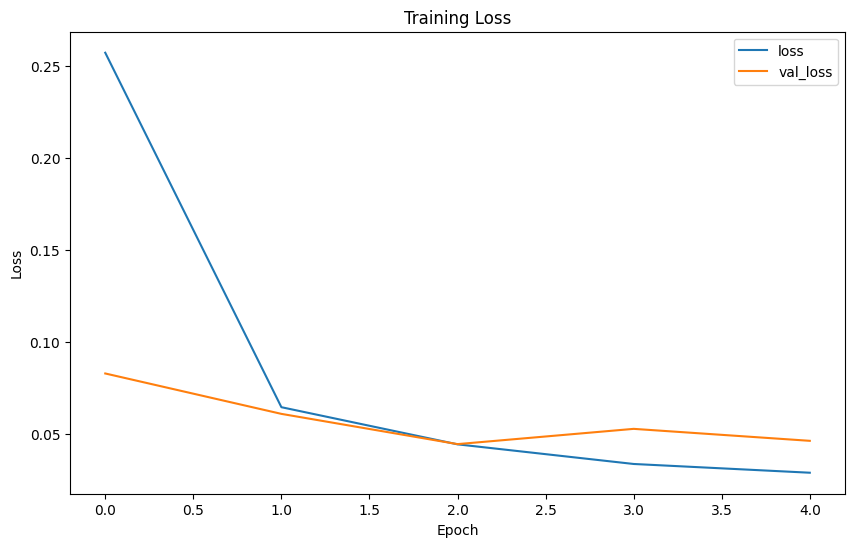

In [5]:
# model fitting
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val), verbose=1)

# Evaluate the model on test data and plot training loss
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


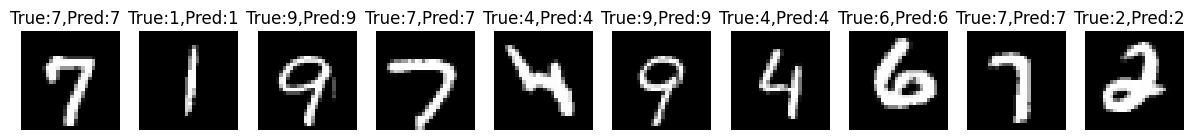

In [6]:
# Visualizzazione delle predizioni

# Funzione per visualizzare alcune immagini di esempio
def plot_examples(x, y_true, y_pred, n=10):
    # istruzione: riempi questa funzione in modo da costruire un grafico di n pannelli,
    # in cui in ogni pannello viene visualizzata un'immagine random del test set,
    # e nel titolo (o come label) vengano scritti anche i valori predetti ed i valori reali (aspettati)
    # questa funzione verrà richiamata anche più in la nel codice
      plt.figure(figsize=(15, 15))
      for i in range(n):
          idx = random.randint(0, len(x) - 1)  # Manca il -1 per evitare errori di indice
          plt.subplot(1, n, i + 1)
          plt.imshow(x[idx].reshape(28, 28), cmap='gray')
          plt.title(f"True:{np.argmax(y_true[idx])},Pred:{np.argmax(y_pred[idx])}  ")
          plt.axis('off')
      #plt.subplots_adjust(wspace=0.5)
      plt.show()
y_pred = model.predict(x_test)

plot_examples(x_test, y_test, y_pred)


# Implementazione di attacchi avversari tramite Adversarial robustness toolbox (ART)

In [7]:
# Creare il classificatore ART
art_classifier = KerasClassifier(model=model, clip_values=(0, 1))
# clip_values è una tupla di due float che rappresentano i valori minimi e massimi consentiti per le caratteristiche di input.


In [8]:
# performiamo un attacco FGSM (Fast Gradient Sign Method) con un epsilon = 0.2 e valutiamo l'accuratezza del modello sulle immagini avversarie.
# per creare un attacco FGSM, creare un'istanza della classe FastGradientMethod e chiamare il metodo generate
# eplison è il parametro che controlla la forza dell'attacco, ovvero quanto l'immagine originale può essere modificata.
epsilon = 0.2
fgsm_attack = FastGradientMethod(estimator=art_classifier, eps=epsilon)
x_test_adv = fgsm_attack.generate(x=x_test)

Accuracy on adversarial examples (ε=0.2): 0.3328


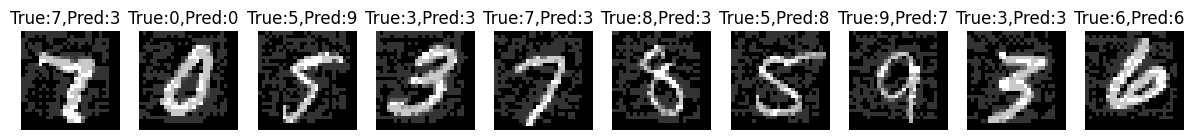

In [9]:
# valutiamo l'accuratezza del modello sulle immagini avversarie
y_pred_adv = art_classifier.predict(x_test_adv)
adv_accuracy = np.sum(np.argmax(y_pred_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial examples (ε={epsilon}): {adv_accuracy:.4f}")

# mostriamo alcuni esempi di predizioni su immagini avversarie random del test set
# chiamando la funzione plot_examples definita in precedenza
plot_examples(x_test_adv, y_test, y_pred_adv)

# Analisi al variare di epsilon

Accuracy on adversarial examples (ε=0.01): 0.9852
Accuracy on adversarial examples (ε=0.05): 0.9576
Accuracy on adversarial examples (ε=0.1): 0.8496
Accuracy on adversarial examples (ε=0.2): 0.3328
Accuracy on adversarial examples (ε=0.3): 0.0899
Accuracy on adversarial examples (ε=0.5): 0.0245


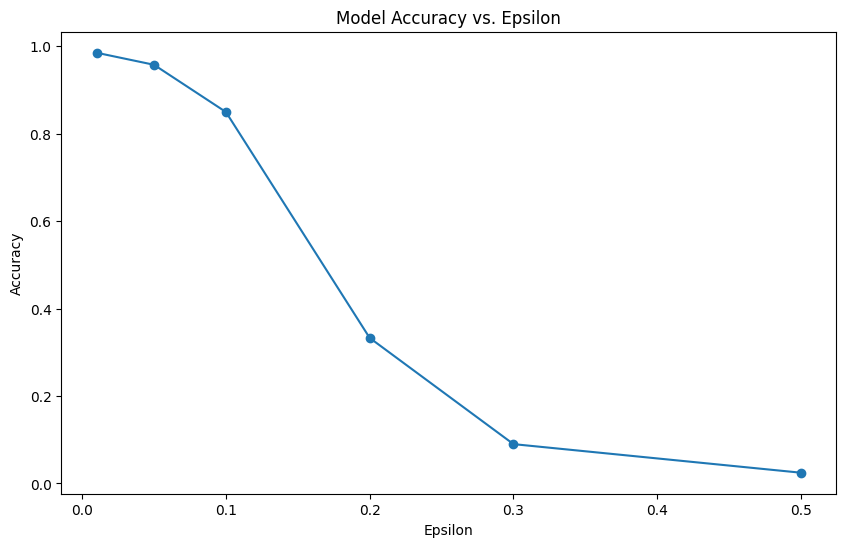

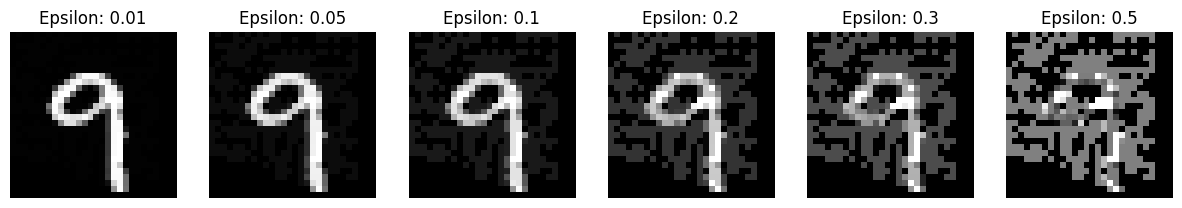

In [12]:
# valori di epsilon con cui vogliamo attaccare il dataset e rispetto ai quali vogliamo valutare l'accuratezza del modello
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]


# istruzione: crea un loop in cui generi attacchi ai diversi valori di epsilon, ed ogni volta ti salvi l'accuratezza del modello
accuracies = []

# Loop attraverso i diversi valori di epsilon
for eps in epsilons:
    # Crea l'attacco FGSM con il valore di epsilon corrente
    fgsm_attack = FastGradientMethod(estimator=art_classifier, eps=eps)

    # Genera gli esempi avversari
    x_test_adv = fgsm_attack.generate(x=x_test)

    # Predice le etichette degli esempi avversari
    y_pred_adv = art_classifier.predict(x_test_adv)

    # Calcola l'accuratezza sugli esempi avversari
    adv_accuracy = np.sum(np.argmax(y_pred_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

    # Aggiungi l'accuratezza alla lista
    accuracies.append(adv_accuracy)

    # Stampa l'accuratezza per il valore di epsilon corrente
    print(f"Accuracy on adversarial examples (ε={eps}): {adv_accuracy:.4f}")

# istruzione: fai una figura di accuratezza vs epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.title("Model Accuracy vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# istrizione: fai una figura in cui fai vedere come una stessa qualsiasi immagine random del dataset viene degradata ai diversi valori di epsilon
# per capire fino a che valore di epsilon la degradazione non e' ovviamente notabile.
plt.figure(figsize=(15, 15))
idx = random.randint(0, len(x_test) - 1)  # Indice casuale dell'immagine

# Loop attraverso i diversi valori di epsilon
for i, eps in enumerate(epsilons):
    # Genera l'immagine avversaria per il valore di epsilon corrente
    fgsm_attack = FastGradientMethod(estimator=art_classifier, eps=eps)
    x_test_adv = fgsm_attack.generate(x=x_test)

    # Mostra l'immagine avversaria
    plt.subplot(1, len(epsilons), i + 1)
    plt.imshow(x_test_adv[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Epsilon: {eps}")
    plt.axis('off')

plt.show()
